In [2]:
import pandas as pd

# Load your CSV into df
df = pd.read_csv(r'C:\Users\hp\Documents\nova-financial-news-sentiment\Nova-financial-news-sentiment-week1\data\raw_analyst_ratings.csv')


In [3]:
# Normalize dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['trading_date'] = df['date'].dt.date

# Since all 'stock' values are 'A', ticker = Agilent Technologies
ticker = "A"

print("Loaded rows:", len(df))

Loaded rows: 55987


In [7]:
import pandas as pd 
from textblob import TextBlob

# Example list of sentences (replace this with your actual data)
stock = [
    "The company reported strong earnings this quarter.",
    "Sales have declined significantly.",
    "Market conditions remain uncertain."
]

# Function to analyze sentiment using TextBlob
def analyze_with_textblob(sentences):
    results = []
    for s in sentences:
        blob = TextBlob(s)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        
        # Simple rule-based sentiment label
        if polarity > 0.1:
            label = "positive"
        elif polarity < -0.1:
            label = "negative"
        else:
            label = "neutral"
        
        results.append({
            "sentence": s,
            "polarity": polarity,
            "subjectivity": subjectivity,
            "textblob_label": label
        })
    return pd.DataFrame(results)

# Now call the function
tb_df = analyze_with_textblob(stock)
print(tb_df)

                                            sentence  polarity  subjectivity  \
0  The company reported strong earnings this quar...  0.433333      0.733333   
1                 Sales have declined significantly.  0.375000      0.875000   
2                Market conditions remain uncertain.  0.000000      0.000000   

  textblob_label  
0       positive  
1       positive  
2        neutral  


In [8]:
import numpy as np

np.random.seed(42)  # for reproducibility

n = 100
x = np.random.normal(loc=0, scale=1, size=n)

# Strong positive correlation with some noise
y = 2 * x + np.random.normal(loc=0, scale=0.5, size=n)

# Strong negative correlation with some noise
z = -1.5 * x + np.random.normal(loc=0, scale=0.5, size=n)

# Almost no correlation (independent)
w = np.random.normal(loc=0, scale=1, size=n)

df_corr = pd.DataFrame({
    "x": x,
    "y": y,
    "z": z,
    "w": w
})

df_corr.head()


,x,y,z,w
0,0.496714,0.285743,-0.566178,-0.828995
1,-0.138264,-0.486851,0.487789,-0.560181
2,0.647689,1.124020,-0.430007,0.747294
3,1.523030,2.644921,-1.757644,0.610370
4,-0.234153,-0.548950,-0.337605,-0.020902


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

df = pd.read_csv(r'C:\Users\hp\Documents\nova-financial-news-sentiment\Nova-financial-news-sentiment-week1\data\raw_analyst_ratings.csv')

sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis on your DataFrame 'df'
df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Preview
df[['headline', 'sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,headline,sentiment
0,Stocks That Hit 52-Week Highs On Friday,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,0.000
2,71 Biggest Movers From Friday,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,0.000
4,B of A Securities Maintains Neutral on Agilent...,0.296


In [ ]:
# Aggregate daily sentiment per stock
daily_sentiment = df.groupby(['stock', 'date'])['sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)

# Preview
daily_sentiment.head()


,stock,date,avg_sentiment
0,A,2009-04-29 00:00:00,0.0000
1,A,2009-06-01 00:00:00,0.2960
2,A,2009-07-14 00:00:00,0.3818
3,A,2009-07-30 00:00:00,0.0000
4,A,2009-08-04 00:00:00,0.0000


In [ ]:
import yfinance as yf

symbol = 'A'
prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')

# Inspect the columns
print(prices.columns)


C:\Users\hp\AppData\Local\Temp\ipykernel_21664\3026178610.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'A'),
            (  'High', 'A'),
            (   'Low', 'A'),
            (  'Open', 'A'),
            ('Volume', 'A')],
           names=['Price', 'Ticker'])


In [ ]:
import yfinance as yf

symbol = 'A'
prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')

# Calculate daily returns using the MultiIndex column
prices['daily_return'] = prices[('Close', symbol)].pct_change()

# Reset index and normalize date
prices = prices.reset_index()
prices['date'] = prices['Date'].dt.date

# Keep only necessary columns
prices = prices[['date', 'daily_return']]
prices.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_21664\1599816391.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')
[*********************100%***********************]  1 of 1 completed


Price,date,daily_return
Ticker,,
0,2020-01-02,NaN
1,2020-01-03,-0.016056
2,2020-01-06,0.002956
3,2020-01-07,0.003065
4,2020-01-08,0.009873


In [ ]:
print("daily_sentiment columns:", daily_sentiment.columns)
print("prices columns:", prices.columns)


daily_sentiment columns: Index(['stock', 'date', 'avg_sentiment'], dtype='object')
prices columns: MultiIndex([(        'date', ''),
            ('daily_return', '')],
           names=['Price', 'Ticker'])


In [ ]:
# Pearson correlation between next-day sentiment and returns
correlation = df_merged['avg_sentiment_next_day'].corr(df_merged['daily_return'])
print(f"Pearson correlation: {correlation:.4f}")


Pearson correlation: 0.0355


In [ ]:
# Keep only rows where both values exist
df_corr = df_plot[['sentiment_lag1', 'return']].dropna()

# Compute correlation
corr_val = pearsonr(df_corr['sentiment_lag1'], df_corr['return'])[0]


In [ ]:
ax1.set_title(f"{symbol} – Next-Day News Sentiment vs Daily Return (r = {corr_val:.3f})")


Text(0.5, 1.0, 'AAPL – Next-Day News Sentiment vs Daily Return (r = 0.036)')

In [ ]:
from scipy.stats import pearsonr

# Keep only rows where both columns are not NaN
df_corr = df_plot[['sentiment_lag1', 'return']].dropna()

# Compute Pearson correlation
corr_val = pearsonr(df_corr['sentiment_lag1'], df_corr['return'])[0]

print(f"Next-day sentiment vs return correlation: {corr_val:.3f}")


Next-day sentiment vs return correlation: 0.036


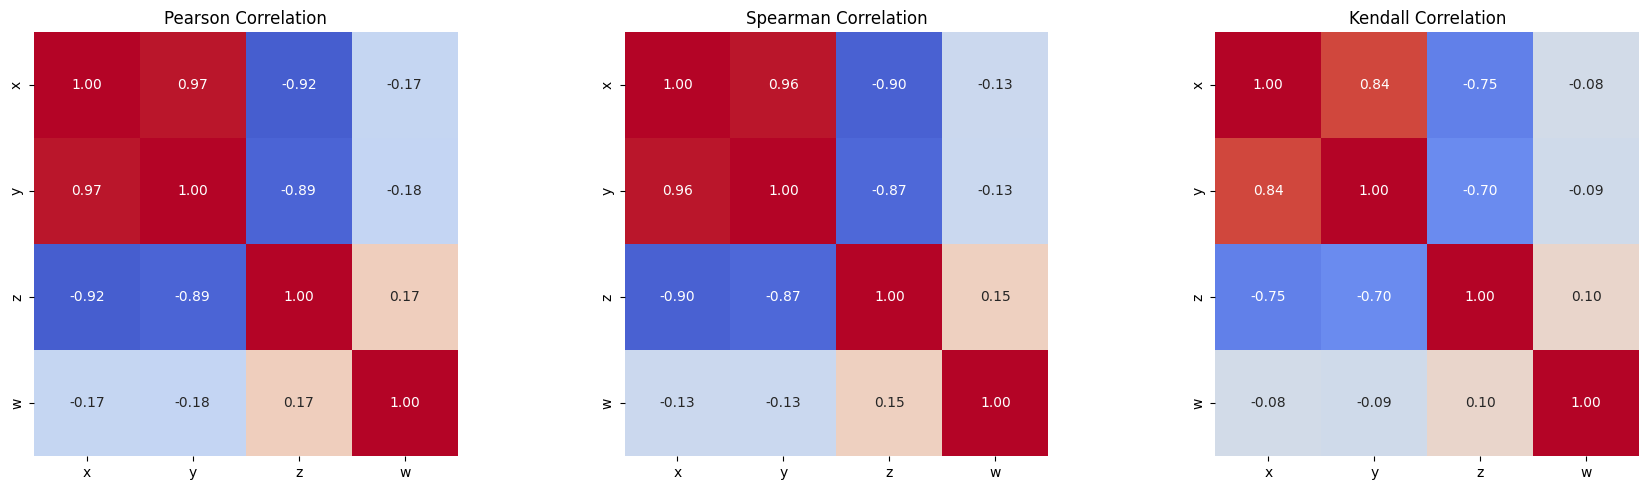

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_methods = {
    "Pearson": df_corr.corr(method="pearson"),
    "Spearman": df_corr.corr(method="spearman"),
    "Kendall": df_corr.corr(method="kendall"),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (title, corr) in zip(axes, corr_methods.items()):
    sns.heatmap(corr, ax=ax, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", square=True, cbar=False)
    ax.set_title(f"{title} Correlation")

fig.tight_layout()
plt.show()


In [ ]:
# Pearson correlation matrix
pearson_corr = df_corr.corr(method="pearson")
print("Pearson correlation matrix:")
print(pearson_corr)

# Spearman correlation matrix
spearman_corr = df_corr.corr(method="spearman")
print("\nSpearman correlation matrix:")
print(spearman_corr)

# Kendall correlation matrix
kendall_corr = df_corr.corr(method="kendall")
print("\nKendall correlation matrix:")
print(kendall_corr)


Pearson correlation matrix:
          x         y         z         w
x  1.000000  0.965494 -0.921069 -0.170227
y  0.965494  1.000000 -0.890392 -0.175088
z -0.921069 -0.890392  1.000000  0.169575
w -0.170227 -0.175088  0.169575  1.000000

Spearman correlation matrix:
          x         y         z         w
x  1.000000  0.964032 -0.902442 -0.125953
y  0.964032  1.000000 -0.874671 -0.134521
z -0.902442 -0.874671  1.000000  0.151947
w -0.125953 -0.134521  0.151947  1.000000

Kendall correlation matrix:
          x         y         z         w
x  1.000000  0.840808 -0.751919 -0.080000
y  0.840808  1.000000 -0.696162 -0.094545
z -0.751919 -0.696162  1.000000  0.100202
w -0.080000 -0.094545  0.100202  1.000000


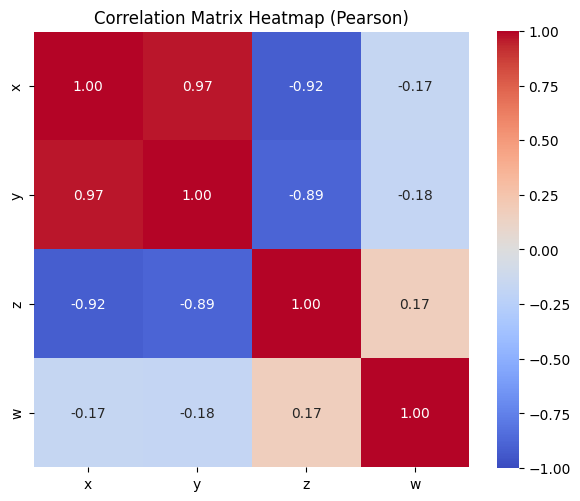

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_corr.corr(method="pearson")

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    square=True,
    cbar=True,
)
plt.title("Correlation Matrix Heatmap (Pearson)")
plt.tight_layout()
plt.savefig(r"C:\Users\hp\Documents\nova-financial-news-sentiment\Nova-financial-news-sentiment-week1\plots/correlation/matrix_heatmap.png")
plt.show()
